# Определение рыночной стоимости объектов недвижимости

- Дано: архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет.
- Необходимо установить параметры, определяющие рыночную стоимость объектов недвижимости, что позволит построить автоматизированную систему, отслеживающую аномалии и мошенническую деятельность.

### Описание данных

- airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
- balcony — число балконов
- ceiling_height — высота потолков (м)
- cityCenters_nearest — расстояние до центра города (м)
- days_exposition — сколько дней было размещено объявление (от публикации до снятия)
- first_day_exposition — дата публикации
- floor — этаж
- floors_total — всего этажей в доме
- is_apartment — апартаменты (булев тип)
- kitchen_area — площадь кухни в квадратных метрах (м²)
- last_price — цена на момент снятия с публикации
- living_area — жилая площадь в квадратных метрах(м²)
- locality_name — название населённого пункта
- open_plan — свободная планировка (булев тип)
- parks_around3000 — число парков в радиусе 3 км
- parks_nearest — расстояние до ближайшего парка (м)
- ponds_around3000 — число водоёмов в радиусе 3 км
- ponds_nearest — расстояние до ближайшего водоёма (м)
- rooms — число комнат
- studio — квартира-студия (булев тип)
- total_area — площадь квартиры в квадратных метрах (м²)
- total_images — число фотографий квартиры в объявлении
- Пояснение: апартаменты — это нежилые помещения, не относящиеся к жилому фонду, но имеющие необходимые условия для проживания.

### Содержание проекта

- [Знакомство с данными и их подготовка](#the_destination)
- [Предобработка данных](#the_destination_1)
- [Исследовательский анализ данных](#the_destination_3)
- [Выводы](#the_destination_4)

<a id='the_destination'></a> 

## Знакомство с данными и их подготовка

In [2]:
import pandas as pd

In [3]:
data_flats_untreated = pd.read_csv('/datasets/real_estate_data.csv', sep='\t', decimal=',')
data_flats = pd.read_csv('/datasets/real_estate_data.csv', sep='\t', decimal=',')

In [4]:
print(data_flats_untreated.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null object
total_area              23699 non-null object
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null object
floors_total            23613 non-null object
living_area             21796 non-null object
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null object
balcony                 12180 non-null object
locality_name           23650 non-null object
airports_nearest        18157 non-null object
cityCenters_nearest     18180 non-null object
parks_around3000        18181 non-null object
parks_nearest           8079 non-null object
ponds_around3000        18

- В данных есть пропуски: ceiling_height, living_area, kitchen_area - необходимо будет найти способ заполнения; is_apartment - предположительно пропуск стоит в случае значения False, balcony - предположительно пропуск стоит в случае отсутсвия балкона, locality_name - пропусков немного (49 штук), восстановить не удастяся. Много пропусков в столбцах, описывающих удаленность от аэропорта, парков. Эта информация берется из карт и ее нет скорее всего из-за сбоев, восстанавливать не будем. В столбце days_exposition около 3000 пропусков.
- Почти все столбцы имеют строковый тип данных вместо численного 

<a id='the_destination_1'></a> 

## Предобработка данных

###### Изменение типа данных

In [5]:
for element in data_flats:
    if element in ['last_price', 'total_area','ceiling_height',  'floors_total', 'living_area', 'kitchen_area', 'balcony', 'days_exposition', 'airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest']:
        data_flats[element] = data_flats[element].astype('float')

In [6]:
data_flats.loc[data_flats['days_exposition'].notnull(), 'days_exposition'] = data_flats.loc[data_flats['days_exposition'].notnull(), 'days_exposition'].astype('int')

In [7]:
print(data_flats.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

In [8]:
#проверим данные в столбце 'balcony' и заменим пропуски на 0, исходя из предположения, что клиенты не указывают количество 
#балконов в случае, когда их нет.
print(data_flats['balcony'].value_counts())
print(data_flats['balcony'].isna().sum())

1.0    4195
0.0    3758
2.0    3659
5.0     304
4.0     183
3.0      81
Name: balcony, dtype: int64
11519


In [9]:
data_flats['balcony'] = data_flats['balcony'].fillna(0)
print(data_flats['balcony'].isna().sum())

0


In [10]:
#Посмотрим данные в столбце 'ceiling_height'.
print(data_flats['ceiling_height'].value_counts())
print(data_flats['ceiling_height'].mean())

2.50      3515
2.60      1646
2.70      1574
3.00      1112
2.80       993
          ... 
27.50        1
5.00         1
3.59         1
4.80         1
100.00       1
Name: ceiling_height, Length: 183, dtype: int64
2.77149889685604


- Значения в диапазоне 22.6-32 похожи на неправильный порядок величины (вместо 32 должно быть 3.2). Напишем функцию, приводящую к требуемому виду

In [11]:
def ceil_height_def(height_of_ceil):
    if height_of_ceil >= 20:
        ceil_height_new = height_of_ceil / 10
    else:
        ceil_height_new = height_of_ceil
    return ceil_height_new   

data_flats['ceiling_height'] = data_flats['ceiling_height'].apply(ceil_height_def)

In [12]:
#выберем из таблицы данные с квартирами, где значения высоты потолка находится в диапазоне (2.4-4.5 м), тк большие или меньшие
#значения похожи на ошибку
data_flats = data_flats[(data_flats['ceiling_height'] < 4.5) & (data_flats['ceiling_height'] > 2.4) | (data_flats['ceiling_height'].isnull())]

In [13]:
print(data_flats['ceiling_height'].isna().sum())

9195


In [14]:
#пропущенные значения заполним средним значением высоты потолков
data_flats['ceiling_height'] = data_flats['ceiling_height'].fillna(data_flats['ceiling_height'].mean())
print(data_flats['ceiling_height'].mean())
print(data_flats['ceiling_height'].isna().sum())

2.7249397089397087
0


Пропущенных значений в столбце floors_total немного (около 60). Заполним их средним значением кол-ва этажей, предварительно сделав проверку, что этаж квартиры не превышает среднего значения столбца floors_total. Если среднее значение floors_total меньше этажа квартиры, то в столбец floors_total проставим значение этажа квартиры.

In [15]:
print(data_flats['floors_total'].mean())

10.683673902884575


In [16]:
data_flats['floors_total'].loc[(data_flats['floors_total'].isnull()) & (data_flats['floor'] > data_flats['floors_total'].mean())] = data_flats['floor']

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [17]:
data_flats['floors_total'].loc[(data_flats['floors_total'].isnull()) & (data_flats['floor'] < data_flats['floors_total'].mean())] = data_flats['floors_total'].mean()

In [18]:
print(data_flats['floors_total'].isna().sum())

0


In [19]:
print(data_flats['living_area'].isna().sum())

1896


In [20]:
#посчитаем сколько составляет средняя доля жилой площади от общей 
data_flats.loc[:, 'new'] = data_flats.loc[data_flats['living_area'].notna(), 'living_area'] / data_flats.loc[data_flats['living_area'].notna(), 'total_area']
data_flats.loc[:, 'part_of_liv_area'] = data_flats.loc[:, 'living_area'] / data_flats.loc[:, 'total_area']
print(data_flats['part_of_liv_area'].mean())

0.5646159461552169


In [21]:
#заполним пропуски посчитав жилую площадь как произведение общей площади на среднюю долю жилой 
data_flats['living_area'] = data_flats['living_area'].fillna(data_flats['part_of_liv_area'].mean()*data_flats['total_area'])
print(data_flats['living_area'].isna().sum())

0


In [22]:
print(data_flats['rooms'].value_counts())

1     8025
2     7914
3     5800
4     1177
5      322
0      196
6      102
7       58
8       12
9        8
10       3
14       2
11       2
19       1
12       1
16       1
15       1
Name: rooms, dtype: int64


In [23]:
#приведем кол-во комнат в студии к единому правилу, будем считать,что кол-во комнат - 0  
data_flats.loc[(data_flats['studio'] == True) & (data_flats['rooms'] == 1), 'rooms'] = 0

In [24]:
print(data_flats['rooms'].value_counts())

1     8014
2     7914
3     5800
4     1177
5      322
0      207
6      102
7       58
8       12
9        8
10       3
14       2
11       2
19       1
12       1
16       1
15       1
Name: rooms, dtype: int64


In [25]:
#pd.pivot_table(data_flats, index=['rooms'], values = 'kitchen_area')

In [26]:
#уберем редкин и большие значения с количесвом записей 1 и 2
data_flats = data_flats[~data_flats['rooms'].isin(['15', '16', '19', '11', '12', '14'])]

In [27]:
#оценим среднюю площадь кухни в зависимости от количесвта комнат
pd.pivot_table(data_flats, index=['rooms'], values = 'kitchen_area')

,kitchen_area
rooms,
1,9.554739
2,9.977482
3,11.308377
4,13.670891
5,18.055957
6,21.102447
7,21.939216
8,24.866667
9,25.071429


In [28]:
#посчитаем сколько в среднем составляет доля кухни от общей площади
data_flats.loc[:, 'new_kitchen'] = data_flats.loc[data_flats['kitchen_area'].notna(), 'kitchen_area'] / data_flats.loc[data_flats['total_area'].notna(), 'total_area']
data_flats.loc[:, 'part_of_kitch_area'] = data_flats.loc[:, 'kitchen_area'] / data_flats.loc[:, 'total_area']
print(data_flats['part_of_kitch_area'].mean())

0.1874221422388766


In [29]:
#заполним пропущенные значения средним значением доли кухни от общей площади 
data_flats['kitchen_area'] = data_flats['kitchen_area'].fillna(data_flats['part_of_kitch_area'].mean()*data_flats['total_area'])
print(data_flats['kitchen_area'].isna().sum())

0


In [30]:
data_flats['locality_name_lower'] = data_flats['locality_name'].str.lower()

In [31]:
data_flats['locality_name_lower'] = data_flats['locality_name_lower'].str.replace('ё','е')

In [32]:
data_flats['first_day_exposition'] = pd.to_datetime(data_flats['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [33]:
data_flats['is_apartment'] = data_flats['is_apartment'].fillna(False)
print(data_flats['is_apartment'].isna().sum())

0


In [34]:
#print(data_flats['locality_name_lower'].unique())

In [35]:
print(data_flats['days_exposition'].mean())
print(data_flats['days_exposition'].median())
#распределение крайне неоднородно, тк среднее значение и медиана отличаются практически в 2 раза

180.8987236539684
95.0


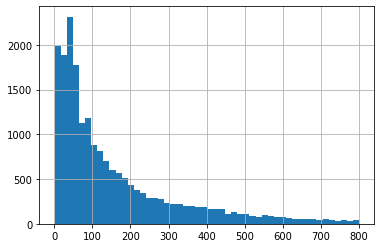

In [36]:
data_flats['days_exposition'].hist(bins=50, range=(1, 800))

In [37]:
print(data_flats['days_exposition'].isnull().sum())
#количесвто пустых значений достаточно велико

3168


In [38]:
import matplotlib.pyplot as plt

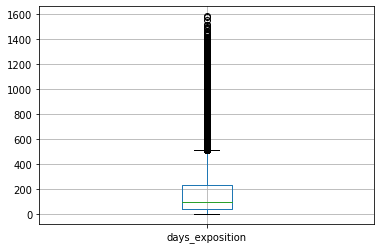

In [39]:
#построим график "ящик с усами", чтобы определить выбросы
data_flats.boxplot(column='days_exposition')
plt.show()

In [40]:
#уберем выбросы
data_flats = data_flats.loc[data_flats['days_exposition'] < 370]
print(data_flats['days_exposition'].mean())
print(data_flats['days_exposition'].median())               

105.70087623847431
74.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb2599c2990>]],
      dtype=object)

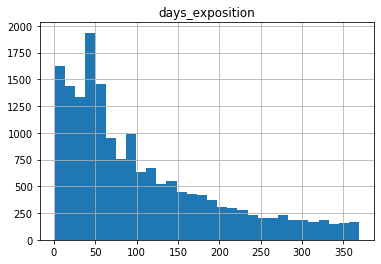

In [41]:
data_flats.hist('days_exposition', bins=30)

In [42]:
data_flats = data_flats.loc[(data_flats['days_exposition'] < 350)]
#data_flats = data_flats[data_flats['days_exposition'] < 350
print(data_flats['days_exposition'].mean())
print(data_flats['days_exposition'].median())  

102.0005810575247
73.0


In [43]:
#уберем выпадающие значения, они похожи на автоматические сроки окончания размещения объявления на сайте
data_flats = data_flats[~data_flats['days_exposition'].isin(['30', '45', '60', '90'])]

In [44]:
print(data_flats['days_exposition'].value_counts())

7.0      233
4.0      176
3.0      158
5.0      152
14.0     145
        ... 
334.0      8
340.0      8
341.0      8
2.0        3
1.0        1
Name: days_exposition, Length: 345, dtype: int64


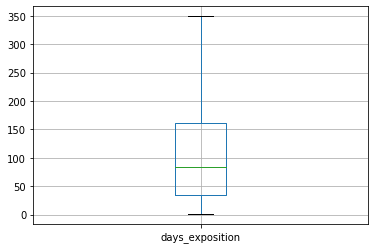

In [45]:
data_flats.boxplot(column='days_exposition')
plt.show()

In [46]:
data_flats['days_exposition'] = data_flats['days_exposition'].fillna(data_flats['days_exposition'].median())
data_flats['days_exposition'] = data_flats['days_exposition'].astype(int)

In [47]:
print(data_flats['days_exposition'].isnull().sum())

0


###### Удаление дубликатов

In [48]:
data_flats.drop_duplicates().reset_index(drop = True)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,new,part_of_liv_area,new_kitchen,part_of_kitch_area,locality_name_lower
0,7,3350000.0,40.40,2018-12-04,1,2.72494,11.0,18.60,1,False,...,0.0,NaN,0.0,NaN,81,0.460396,0.460396,0.272277,0.272277,поселок шушары
1,2,10000000.0,100.00,2018-06-19,2,3.03000,14.0,32.00,13,False,...,2.0,112.0,1.0,48.0,121,0.320000,0.320000,0.410000,0.410000,санкт-петербург
2,10,2890000.0,30.40,2018-09-10,1,2.72494,12.0,14.40,5,False,...,NaN,NaN,NaN,NaN,55,0.473684,0.473684,0.299342,0.299342,городской поселок янино-1
3,6,3700000.0,37.30,2017-11-02,1,2.72494,26.0,10.60,6,False,...,0.0,NaN,0.0,NaN,155,0.284182,0.284182,0.386059,0.386059,поселок парголово
4,20,2900000.0,33.16,2018-05-23,1,2.72494,27.0,15.43,26,False,...,NaN,NaN,NaN,NaN,189,0.465320,0.465320,0.265682,0.265682,поселок мурино
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15382,6,3200000.0,39.00,2017-12-16,1,2.72494,9.0,20.00,6,False,...,0.0,NaN,0.0,NaN,38,0.512821,0.512821,0.282051,0.282051,санкт-петербург
15383,19,9200000.0,101.00,2019-04-01,3,3.05000,15.0,63.00,12,False,...,0.0,NaN,0.0,NaN,23,0.623762,0.623762,0.148515,0.148515,санкт-петербург
15384,13,3550000.0,35.30,2018-02-28,1,2.86000,15.0,16.30,4,False,...,1.0,353.0,2.0,652.0,29,0.461756,0.461756,0.257790,0.257790,санкт-петербург
15385,3,5500000.0,52.00,2018-07-19,2,2.72494,5.0,31.00,2,False,...,1.0,300.0,0.0,NaN,15,0.596154,0.596154,0.115385,0.115385,санкт-петербург


In [49]:
print(data_flats.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15387 entries, 1 to 23693
Data columns (total 27 columns):
total_images            15387 non-null int64
last_price              15387 non-null float64
total_area              15387 non-null float64
first_day_exposition    15387 non-null datetime64[ns]
rooms                   15387 non-null int64
ceiling_height          15387 non-null float64
floors_total            15387 non-null float64
living_area             15387 non-null float64
floor                   15387 non-null int64
is_apartment            15387 non-null bool
studio                  15387 non-null bool
open_plan               15387 non-null bool
kitchen_area            15387 non-null float64
balcony                 15387 non-null float64
locality_name           15353 non-null object
airports_nearest        12004 non-null float64
cityCenters_nearest     12020 non-null float64
parks_around3000        12020 non-null float64
parks_nearest           5170 non-null float64
ponds_ar

###### Добавление данных

In [50]:
#добавим новый столбец с ценой квадратного метра
data_flats['m2_price'] = data_flats['last_price'] / data_flats['total_area']

In [51]:
#добавим день недели публикации
data_flats['weekday'] = data_flats['first_day_exposition'].dt.day_name()
#print(data_flats['weekday'].sort_values())

In [52]:
#добавим месяц публикации
data_flats['month'] = data_flats['first_day_exposition'].dt.month
#print(data_flats['month'].sort_values())

In [53]:
#добавим год публикации
data_flats['year'] = data_flats['first_day_exposition'].dt.year
#print(data_flats['year'].sort_values())

Добавим стобец с категориями этажности: первый, последний, другое

In [54]:
def floor_category(floor):
        if floor['floor'] == 1:
            return 'первый'
        elif floor['floor'] == floor['floors_total']:
            return 'последний'
        else:
            return 'другой'
        
data_flats['floor_category'] = data_flats.apply(floor_category, axis=1)

In [55]:
data_flats['part_of_kitch_area_new'] = data_flats['kitchen_area'] / data_flats['total_area']

In [56]:
data_flats['part_of_living_area_new'] = data_flats['living_area'] / data_flats['total_area']

<a id='the_destination_3'></a> 

## Исследовательский анализ данных

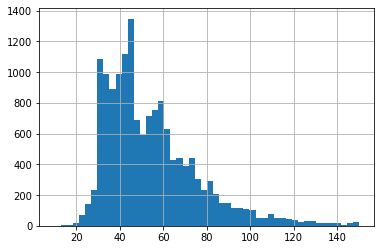

In [57]:
data_flats['total_area'].hist(bins=50, range=(10, 150))

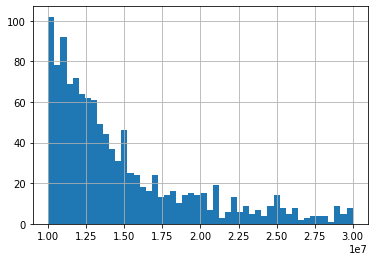

In [58]:
data_flats['last_price'].hist(bins=50, range=(1e+07,3e+07))

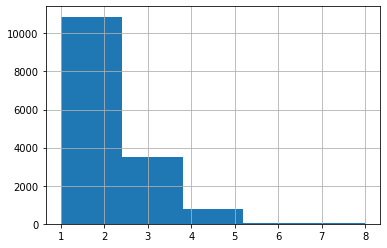

In [59]:
data_flats['rooms'].hist(bins=5, range=(1,8))

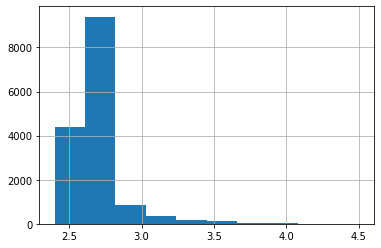

In [60]:
data_flats['ceiling_height'].hist(bins=10, range=(2.4,4.5))

#### Время продажи квартиры

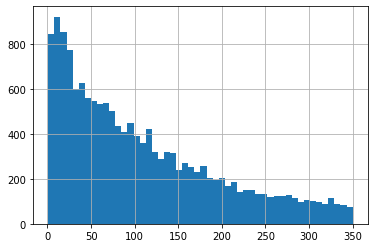

In [61]:
data_flats['days_exposition'].hist(bins=50, range=(1, 350))

In [62]:
print(data_flats['days_exposition'].min())
print(data_flats['days_exposition'].max())
print(data_flats['days_exposition'].mean())
print(data_flats['days_exposition'].median())

1
349
107.83453564697471
84.0


Большое количество продаж сроком до 30 дней выглядит неправдоподобно.Уберем их и расчитаем среднее значение параметра days_exposition

In [63]:
#print(data_flats.groupby('days_exposition')['days_exposition'].count().head(35))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb25713f610>]],
      dtype=object)

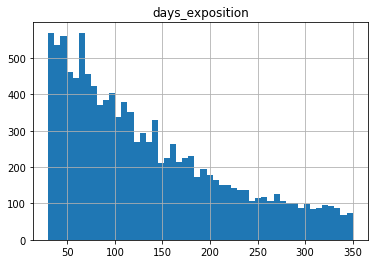

In [64]:
data_flats.query('days_exposition > 30').hist('days_exposition', bins=50, range=(30, 350))

In [65]:
data_clean_daysexp = data_flats.loc[data_flats['days_exposition']>30]
print(data_clean_daysexp['days_exposition'].mean())
print(data_clean_daysexp['days_exposition'].median())

135.34998736203556
114.0


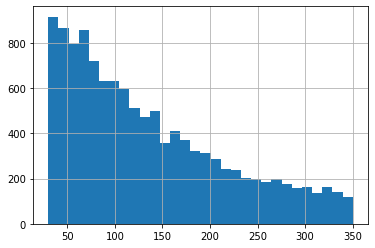

In [66]:
data_clean_daysexp['days_exposition'].hist(bins=30, range=(30, 350))

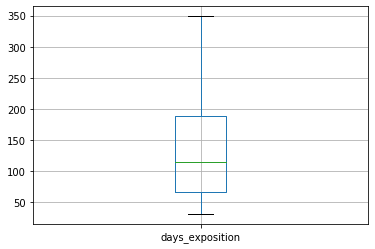

In [67]:
data_clean_daysexp.boxplot(column='days_exposition')
plt.show()

In [68]:
print(data_clean_daysexp['days_exposition'].describe())

count    11869.000000
mean       135.349987
std         83.224161
min         31.000000
25%         66.000000
50%        114.000000
75%        188.000000
max        349.000000
Name: days_exposition, dtype: float64


Продажа обычно занимает 114 дней (определили как медиану распределения). Быстрой продажей будем считать продажу менее, чем за 66 дней, а долгой более 188. 

####  Факторы, больше всего влияющие на стоимость квартиры


Определим от каких факторов зависит цена кв. м.

In [69]:
data_place = data_flats.loc[(data_flats['cityCenters_nearest'].notna())& (data_flats['cityCenters_nearest']<37000)]

In [70]:
pd.set_option('display.max_columns', None)

In [71]:
data_place['cityCenters_nearest'].isnull().sum()

0

In [72]:
print(data_place['cityCenters_nearest'].corr(data_flats['last_price']))

-0.19143080165716236


In [73]:
for element in data_flats:
    if element in ['total_area', 'living_area', 'kitchen_area', 'rooms', 'cityCenters_nearest']:
        print(element, data_flats['last_price'].corr(data_flats[element]))

total_area 0.5969869144093254
rooms 0.32501212884597747
living_area 0.5364305371069992
kitchen_area 0.4677326508995199
cityCenters_nearest -0.17802830562147617


Наибольший коэффициент корелляции 0.6 между ценой квартиры и ее площадью, далее идут по убыванию: жилая площадь, площадь кухни, количество комнат,расстояние до центра.

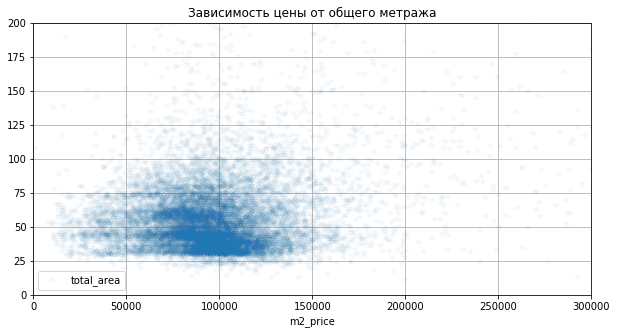

In [74]:
data_flats.plot(title='Зависимость цены от общего метража', x=('m2_price'), y='total_area', style='*', grid=True, figsize=(10, 5), xlim=(0,300000), ylim=(0,200), alpha=0.03)

При увеличении метража квартиры, цена на кв. метр снижается.

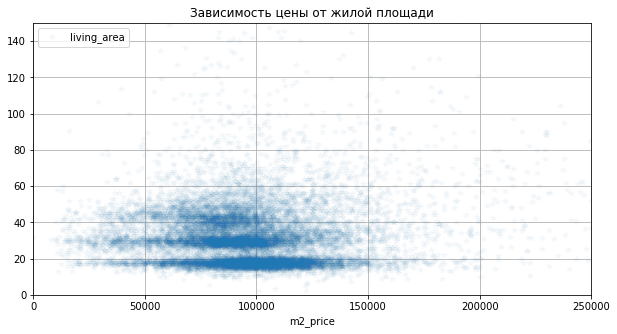

In [75]:
data_flats.plot(title='Зависимость цены от жилой площади', x=('m2_price'), y='living_area', style='*', grid=True, figsize=(10, 5), xlim=(0,250000), ylim=(0,150), alpha=0.03)

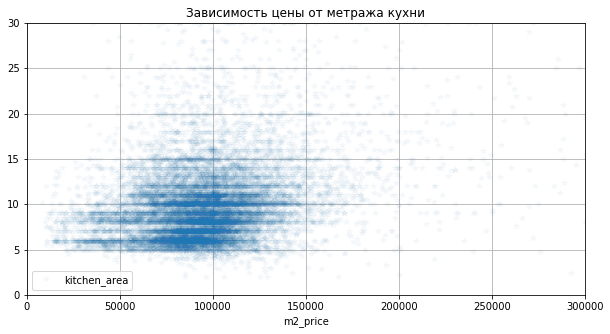

In [76]:
data_flats.plot(title='Зависимость цены от метража кухни', x=('m2_price'), y='kitchen_area', style='*', grid=True, figsize=(10, 5), xlim=(0,300000), ylim=(0,30), alpha=0.03)

С увеличением метража кухни, цена на кв. м. увеличивается

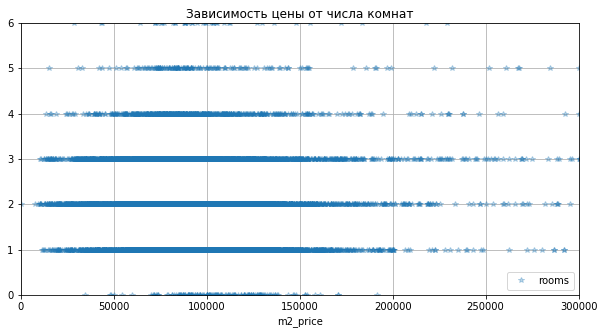

In [77]:
data_flats.plot(title='Зависимость цены от числа комнат', x=('m2_price'), y='rooms', style='*', grid=True, figsize=(10, 5), xlim=(0,300000), ylim=(0,6), alpha=0.3)

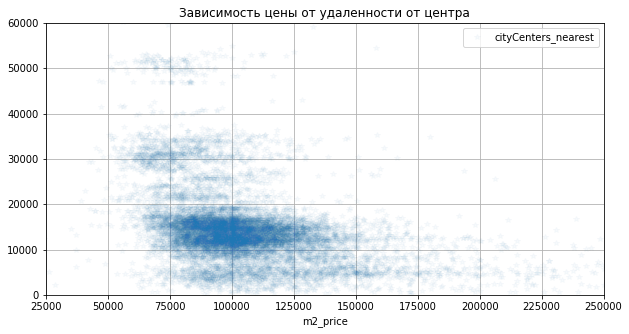

In [78]:
data_flats.plot(title='Зависимость цены от удаленности от центра', x=('m2_price'), y='cityCenters_nearest', style='*', grid=True, figsize=(10, 5), xlim=(25000,250000), ylim=(0,60000), alpha=0.03)

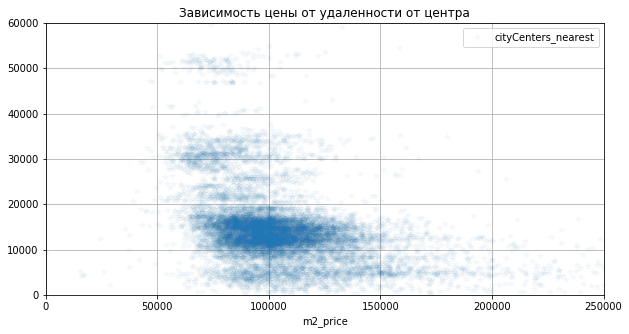

In [79]:
data_flats.plot(title='Зависимость цены от удаленности от центра', x=('m2_price'), y='cityCenters_nearest', style='*', grid=True, figsize=(10, 5), xlim=(0,250000), ylim=(0,60000), alpha=0.03)

Цена кв. м. становится меньше при удалении от центра

In [80]:
m2_floorcat_mean = data_flats.groupby('floor_category')['m2_price'].median() 
print(m2_floorcat_mean)

floor_category
другой       96997.690531
первый       81469.648562
последний    88729.016787
Name: m2_price, dtype: float64


Средняя стоимость кв.м. на первом этаже на 8% меньше, чем на последнем и на 16% меньше, чем на любом другом.

In [81]:
data_flats.pivot_table(index='weekday', values='m2_price', aggfunc='median')

,m2_price
weekday,
Friday,93665.158371
Monday,94632.768362
Saturday,93902.439024
Sunday,92992.762128
Thursday,94047.619048
Tuesday,94852.941176
Wednesday,94898.590798


В зависимости от дня недели публикации объявления, цена на кв. м может отличаться в пределах 2%. Наибольшая стоимость в среду, наименьшая - в субботу.

In [82]:
data_flats.pivot_table(index='month', values='m2_price', aggfunc='median')

,m2_price
month,
1,95161.290323
2,94444.444444
3,94662.408759
4,93333.333333
5,93000.000000
6,92307.692308
7,93630.573248
8,96923.076923
9,95065.789474


В зависимости от месяца публикации объявления цена на кв. м. может изменяется в пределах 5.2%. Максимальная стоимость в августе, минимальная - в июне.

In [83]:
price_year = data_flats.pivot_table(index='year', values='m2_price', aggfunc=['median'])
print(price_year)


             median
           m2_price
year               
2015   90438.896611
2016   91987.731597
2017   91935.483871
2018   95717.267364
2019  104284.627606


С 2015 по 2019 год стоимость кв. м. возросла на 13%.

#### 10 населенных пунктов с максимальным числом объявлений


In [84]:
#data_flats.pivot_table(index='locality_name_lower', aggfunc='count')

In [85]:
data_number = data_flats.groupby('locality_name_lower')['locality_name_lower'].count().sort_values(ascending = False).head(10)
print(data_number)

locality_name_lower
санкт-петербург      10343
поселок мурино         452
поселок шушары         316
всеволожск             252
колпино                242
пушкин                 238
деревня кудрово        222
поселок парголово      221
гатчина                194
выборг                 146
Name: locality_name_lower, dtype: int64


In [86]:
#m2_price_in_places = data_flats.pivot_table(index='locality_name_lower', values='m2_price', aggfunc='median')
#print(m2_price_in_places)

In [87]:
m2_price_in_places = data_flats.pivot_table(index='locality_name_lower', values='m2_price', aggfunc='median')

In [88]:
m2_price_in_places.join(data_number, how='right' )

,m2_price,locality_name_lower
locality_name_lower,,
санкт-петербург,102678.571429,10343
поселок мурино,85697.390514,452
поселок шушары,76343.750000,316
всеволожск,65789.473684,252
колпино,73629.112662,242
пушкин,97882.115643,238
деревня кудрово,92044.864227,222
поселок парголово,91237.361579,221
гатчина,66920.289855,194


10 городов с наибольшим количеством объявлений. Максимальная стоимость кв.м в Санкт-Петербурге, минимальная - в Выборге

In [89]:
data_flats_Peter = data_flats.loc[(data_flats['cityCenters_nearest'].notna())&(data_flats['locality_name_lower']=='санкт-петербург')]
                                                                               

In [90]:
data_flats_Peter['to_center_km'] = data_flats_Peter['cityCenters_nearest']/1000
data_flats_Peter['to_center_km'] = data_flats_Peter['to_center_km'].astype(int)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [91]:
data_to_plot = data_flats_Peter.pivot_table(index='to_center_km', values='m2_price')

In [92]:
data_to_plot

,m2_price
to_center_km,
0,171776.691228
1,157592.864484
2,136423.663463
3,126617.561729
4,133512.738133
5,142228.651647
6,138759.869032
7,140776.432022
8,115573.163976


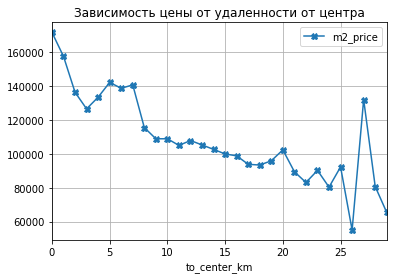

In [93]:
data_to_plot.plot(title='Зависимость цены от удаленности от центра', marker = 'X', grid=True)

In [94]:
#квартиры с наибольшей стоимостью находятся в пределах 7 км от центра
for element in data_flats_Peter.query('to_center_km <= 7'):
    if element in ['total_area', 'living_area', 'kitchen_area', 'last_price', 'rooms', 'ceiling_height']:
        print(element, data_flats_Peter.query('to_center_km <= 7')[element].mean(), data_flats_Peter.query('to_center_km <= 7')[element].corr(data_flats['m2_price']))
    

last_price 13018772.70047619 0.8262591902725803
total_area 84.37949523809525 0.2911714251465834
rooms 2.6433333333333335 0.04549022279427675
ceiling_height 2.921014667854667 0.0338416336540585
living_area 49.21789535448194 0.22662969892320914
kitchen_area 13.732335219504536 0.3646532383242223


In [95]:
for element in data_flats_Peter.query('to_center_km > 7'):
    if element in ['total_area', 'living_area', 'kitchen_area', 'last_price', 'rooms', 'ceiling_height']:
        print(element, data_flats_Peter.query('to_center_km > 7')[element].mean(), data_flats_Peter.query('to_center_km > 7')[element].corr(data_flats['m2_price']))


last_price 5606354.989546615 0.5258532019511154
total_area 53.947799927069404 0.025579635155293552
rooms 1.9095660629634132 -0.2308894135210607
ceiling_height 2.681363197139786 0.24422573140077267
living_area 30.542780365868644 -0.08545654113608611
kitchen_area 9.760644308971512 0.26472954031037843


Квартиры в центре города и вне сильно отличаются по своим характеристикам: 
- стоимость и общая(а также жилая и площадь кухни) квартиры в центре примерно в 2 и 1,5 раза, соответственно, больше
- количество комнат в среднем больше на одну
- высота потолков в среднем больше на 20 см


Существенно отличается корреляция между ценой кв.м. в центре и вне центра города. В центре города цена на кв. м. кореллирует с размером общей площади, жилой и кухни в квартире. На окраинах цена кв. м. кореллирует с площадью кухни и высотой потолков.

<a id='the_destination_4'></a> 

# Выводы

В данном проекте проведена подготовка исходных данных: заменены пропуски в случае необходимости, удалены дубликаты, изменен тип данных объектов.
В результате анализа данных получены следующие результаты: 
- уведичение метража квартиры и расстояния до центра приводит к уменьшению стоимости кв. м. Увеличение размера кухни приводит к увеличению стоимости кв.м.
- стоимость квартиры на первом этаже меньше на 16%, чем на любом другом и на 8% меньше стоимости квартиры на последнем этаже
- цена квартиры зависит от общей, жилой площади и площади кухни. В меньшей степени от количества комнат и в еще меньшей от расстояния до центра.
- цена на кв. м. зависит от дня (разница до 2%) и месяца публикации объявления (разница до 5%)
- с 2015 по 2019 г. цена на кв. м.  выросла на 13%
- квартиры в центре и на окраинах Санкт-Петербурга значительно отличаются по своим характеристикам и стоимость кв. м. по разному кореллирует с характеристиками квартиры.